In [1]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate
from scipy import stats
from scipy.stats import normaltest
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
# logistic regression model
from sklearn.linear_model import LogisticRegression
# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve
# KNN imputation
from sklearn.impute import KNNImputer
# normalizer
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# RFECV
from sklearn.model_selection import StratifiedKFold
# random forest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics
from sklearn.metrics import accuracy_score # Accuracy classification score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to show confusion matrix
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from sklearn import decomposition
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap

Read files 

In [2]:
def read_secom():
    path ='../secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_labels():
    path = '../secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
df_features = read_secom()
df_target = read_labels()

# Data Preparation

## Merge data

In [3]:
df= pd.concat([df_features,df_target],axis=1)

## Split Training and test data 

In [4]:
x = df.iloc[:,:590]
y = df.iloc[:,590]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1,stratify=y)

In [5]:
x_train.isna().sum().sum()

33219

## reducing dimensionality 

### remove missing values 

In [6]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [7]:
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
...,...,...
feature500,1,0.079808
feature367,1,0.079808
feature377,1,0.079808
feature378,1,0.079808


In [8]:
miss_threshold=80
x_train_na= x_train_na[x_train_na["Percentage (%)"] > miss_threshold]
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [9]:
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 582)

### removing constant voltality

In [10]:
x_train_new_eda= x_train_new.describe().T
x_train_new_eda

,count,mean,std,min,25%,50%,75%,max
feature1,1248.0,3014.113686,73.877303,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500
feature2,1247.0,2496.400585,79.188651,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400
feature3,1243.0,2200.216525,29.939025,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667
feature4,1243.0,1394.907987,436.632421,0.0000,1083.8858,1283.43680,1593.122000,3715.0417
feature5,1243.0,4.018582,54.572445,0.6815,1.0160,1.31710,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
feature586,1252.0,3.084501,3.968128,1.1975,2.3058,2.74655,3.258475,99.3032
feature587,1252.0,0.021521,0.012421,-0.0060,0.0134,0.02070,0.027600,0.1028
feature588,1252.0,0.016344,0.008698,0.0042,0.0106,0.01480,0.019800,0.0799
feature589,1252.0,0.005248,0.002850,0.0012,0.0033,0.00460,0.006300,0.0286


In [11]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

## Outlier Treatment

In [13]:
x_train_3s=x_train_new_2.copy()

In [14]:
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [15]:
zscore(x_train_3s,x_train_3s.columns,3)

# Checking

In [16]:
x_train_new_2['feature4'].mean()

1394.907986725665

In [17]:

x_train_new_2['feature4'].std()

436.63242083048897

In [20]:
x_train_new_2['feature4'].mean()+3*x_train_new_2['feature4'].std()

2704.805249217132

In [21]:
x_train_new_2['feature4'].max()

3715.0417

In [22]:
x_train_3s['feature4'].max()


2704.805249217132

## Imputation

### KNN Imputation

In [23]:
#scaling before distanced based algo
scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
x_train_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [24]:
# impute missing values and save it as a temporary dataset.
# as per Aras research you need to separately scale before knn imputataion
#use fit_transform on training data and only transform on test data
knn = KNNImputer()
#knn.fit(x_train_scaled)
#imputed_train = pd.DataFrame(knn.fit_transform(x_train_3s), columns = x_train_3s.columns)
imputed_train = pd.DataFrame(knn.fit_transform(x_train_scaled), columns = x_train_scaled.columns)

# Checking

In [25]:
imputed_train.isna().sum().sum()

0

In [26]:
imputed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,0.423344,0.230365,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,0.277819,0.172041,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,0.236661,0.336388,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,0.217552,0.130255,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,0.249890,0.155535,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,0.318978,0.106352,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [27]:
retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

In [28]:
retransformed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3079.77,2354.51,2207.0444,1269.607800,1.7571,97.018900,0.1221,1.4607,0.0155,0.0093,...,0.00590,68.74440,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
1,3001.36,2491.23,2155.3111,918.216100,1.2753,105.047800,0.1227,1.4206,-0.0052,0.0010,...,0.00696,83.34452,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
2,3042.78,2377.89,2173.4556,1433.673200,1.0304,110.542200,0.1245,1.4964,0.0204,0.0133,...,0.00498,62.24328,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
3,3018.64,2401.80,2224.0000,1510.079700,1.5611,99.830000,0.1199,1.4428,-0.0110,0.0101,...,0.00380,49.74900,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
4,3020.29,2433.99,2217.8111,1744.777100,0.9618,100.178900,0.1218,1.4950,-0.0097,-0.0054,...,0.00442,121.70308,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,3057.31,2481.53,2214.9333,1663.702400,1.0203,100.445600,0.1247,1.4830,-0.0328,0.0048,...,0.00416,47.12526,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
1249,3009.71,2565.53,2224.6778,1308.647900,1.3907,101.133300,0.1208,1.4440,-0.0079,-0.0076,...,0.00460,56.27146,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
1250,3034.34,2631.47,2179.0445,2028.220800,1.5552,95.425600,0.1234,1.4281,0.0049,0.0092,...,0.00554,38.47760,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1251,3025.21,2503.30,2179.7333,2704.805249,1.4843,82.357569,0.1248,1.3687,-0.0070,-0.0033,...,0.00160,46.10760,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


## Feature Selection

Boruta

In [29]:
#Boruta function with random forest

def BorutaFeatureSelection (X, y,bor_iter) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    
    # define Boruta feature selection method
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=bor_iter)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking

In [30]:
# apply Boruta and store selected features in a variable
#X_train , final_features = BorutaFeatureSelection(imputed_train,y_train,145)
# boruta on reversed scaled data 
X_train , final_features, feature_ranking = BorutaFeatureSelection(retransformed_train,y_train,140)# 132 iterations result in 14

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:260: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:265: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

Iteration: 	1 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 140
Confirmed: 	0
Tentative: 	16
Rejected: 	450
Iteration: 	9 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	10 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	11 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	12 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	13 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	14 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	15 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	16 / 140
Confirmed: 	4
Tentat

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:319: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:325: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


###  function for boruta with different models

In [40]:
#Boruta function with random forest

def BorutaFSModel (X, y,m,bor_iter) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    if m=='Rf':
        print('\n',"Boruta with ",m," as classifier",'\n')
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
        model.fit(X, y)
    elif m=='XGB':
        print('\n',"Boruta with ",m," as classifier",'\n')
        model = XGBClassifier()
        model.fit(X,y)
    # define Boruta feature selection method
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=bor_iter)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking

In [42]:
bor_clf = ['Rf', 'XGB']
bor_noit=140
for m in bor_clf:
    if m=='Rf':
        X_train_rf , final_features_rf, feature_ranking_rf = BorutaFSModel(retransformed_train,y_train,m,bor_noit)
    elif m== 'XGB':
        X_train_xgb , final_features_xgb, feature_ranking_xgb = BorutaFSModel(retransformed_train,y_train,m,bor_noit)


 Boruta with  Rf  as classifier 



c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:260: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:265: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

Iteration: 	1 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 140
Confirmed: 	0
Tentative: 	16
Rejected: 	450
Iteration: 	9 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	10 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	11 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	12 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	13 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	14 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	15 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	16 / 140
Confirmed: 	4
Tentat

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:319: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:325: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


NameError: name 'XGBClassifier' is not defined

RFE

In [31]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [32]:
#RFE function with random forest

def RFEFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)

    # define RFE feature selection method
    rfe = RFE(estimator = model,n_features_to_select = 15)

    # find all relevant features
    rfe.fit(X,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    print(final_features_rfe)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features_rfe)) , final_features_rfe

In [34]:
# apply RFE and store selected features in a variable
X_train_rfe, final_features_rfe = RFEFeatureSelection(retransformed_train,y_train)

Feature: feature1                       Rank: 1,  Keep: True
Feature: feature2                       Rank: 286,  Keep: False
Feature: feature3                       Rank: 308,  Keep: False
Feature: feature4                       Rank: 95,  Keep: False
Feature: feature5                       Rank: 289,  Keep: False
Feature: feature7                       Rank: 210,  Keep: False
Feature: feature8                       Rank: 145,  Keep: False
Feature: feature9                       Rank: 71,  Keep: False
Feature: feature10                      Rank: 371,  Keep: False
Feature: feature11                      Rank: 79,  Keep: False
Feature: feature12                      Rank: 215,  Keep: False
Feature: feature13                      Rank: 242,  Keep: False
Feature: feature15                      Rank: 219,  Keep: False
Feature: feature16                      Rank: 158,  Keep: False
Feature: feature17                      Rank: 2,  Keep: False
Feature: feature18                      Rank: 56

In [35]:
from sklearn.svm import SVC

In [36]:
#RFE function with SVM
#used scaled data

def RFESVMFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = SVC(kernel='linear',C=5)
    model.fit(X, y)

    # define RFE feature selection method
    rfe = RFECV(estimator = model,scoring='accuracy')

    # find all relevant features
    rfe.fit(X,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features_rfesvm = list()
    indexes = np.where(rfe.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features_rfesvm.append(feature_names[x])
    print(final_features_rfesvm)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features_rfesvm)) , final_features_rfesvm

In [37]:
# apply RFE and store selected features in a variable
X_train_rfesvm, final_features_rfesvm = RFESVMFeatureSelection(imputed_train,y_train)

Feature: feature1                       Rank: 40,  Keep: False
Feature: feature2                       Rank: 135,  Keep: False
Feature: feature3                       Rank: 122,  Keep: False
Feature: feature4                       Rank: 276,  Keep: False
Feature: feature5                       Rank: 429,  Keep: False
Feature: feature7                       Rank: 131,  Keep: False
Feature: feature8                       Rank: 41,  Keep: False
Feature: feature9                       Rank: 213,  Keep: False
Feature: feature10                      Rank: 120,  Keep: False
Feature: feature11                      Rank: 61,  Keep: False
Feature: feature12                      Rank: 84,  Keep: False
Feature: feature13                      Rank: 285,  Keep: False
Feature: feature15                      Rank: 29,  Keep: False
Feature: feature16                      Rank: 174,  Keep: False
Feature: feature17                      Rank: 196,  Keep: False
Feature: feature18                      Rank:

Boruta Shap with different classifiers(RF,SVC,XCBoost)

In [ ]:
from BorutaShap import BorutaShap

In [ ]:
#Boruta Shap function with random forest

def BorutaShapFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


10 attributes confirmed important: ['feature104', 'feature520', 'feature164', 'feature435', 'feature248', 'feature299', 'feature478', 'feature469', 'feature34', 'feature60']
456 attributes confirmed unimportant: ['feature352', 'feature556', 'feature10', 'feature427', 'feature106', 'feature542', 'feature276', 'feature69', 'feature442', 'feature21', 'feature366', 'feature358', 'feature38', 'feature120', 'feature569', 'feature410', 'feature216', 'feature113', 'feature184', 'feature333', 'feature458', 'feature30', 'feature318', 'feature154', 'feature543', 'feature204', 'feature460', 'feature433', 'feature312', 'feature383', 'feature408', 'feature178', 'feature57', 'feature274', 'feature268', 'feature19', 'feature128', 'feature2', 'feature20', 'feature341', 'feature123', 'feature311', 'feature332', 'feature107', 'feature317', 'feature213', 'feature580', 'feature250', 'feature490', 'feature445', 'feature302', 'feature229', 'feature301', 'feature434', 'feature378', 'feature117', 'feature63', 

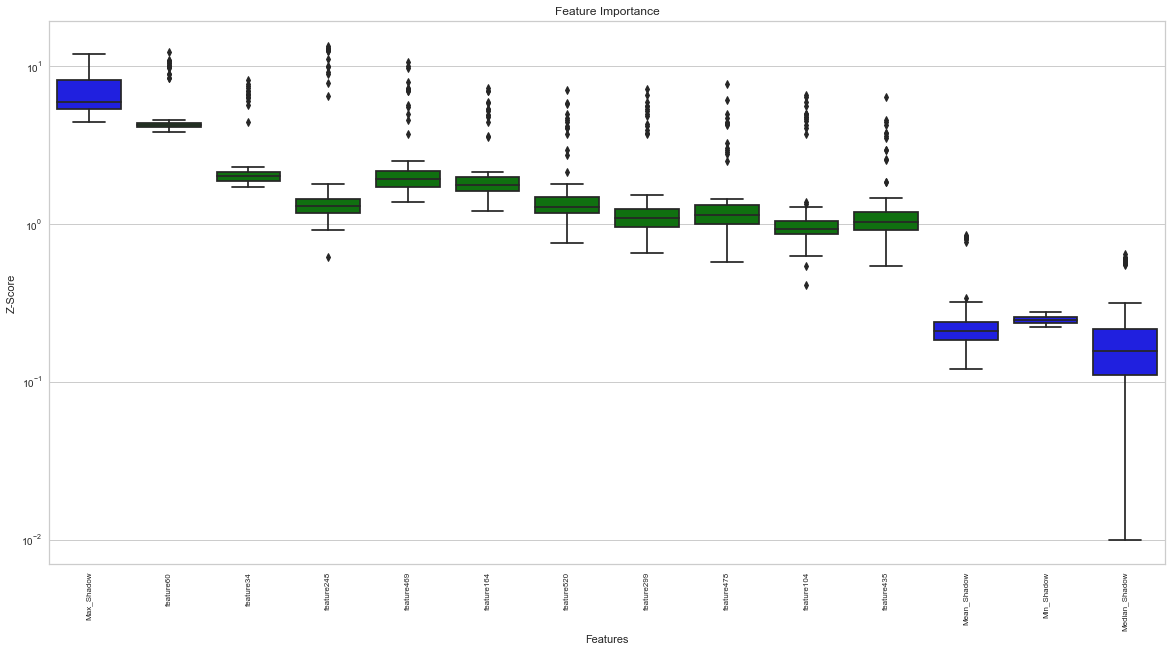

In [ ]:
X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train)

In [ ]:
X_trainshap

,feature104,feature520,feature164,feature435,feature248,feature299,feature478,feature469,feature34,feature60
0,-0.0095,3.292400,0.128,9.9805,0.015200,0.0595,6.0266,0.0000,8.6915,0.6991
1,-0.0163,6.713220,0.157,12.5349,0.031060,0.0662,4.8218,0.0000,8.3006,-1.4173
2,-0.0108,7.439200,0.127,12.8413,0.034500,0.0519,6.1589,50.6084,8.7418,10.2355
3,-0.0038,61.263283,0.135,10.5202,0.260816,0.0635,5.0612,63.4401,8.6829,9.8518
4,-0.0119,3.731840,0.108,11.1054,0.017220,0.0505,7.4828,432.4538,8.5891,1.0336
...,...,...,...,...,...,...,...,...,...,...
1248,-0.0083,4.053080,0.103,10.2005,0.018680,0.0449,4.6390,328.5436,9.1156,3.2964
1249,-0.0115,4.373000,0.098,7.7608,0.020300,0.0474,6.6740,315.3685,8.4278,3.0345
1250,-0.0067,29.569300,0.154,12.0903,0.138300,0.0721,6.3958,23.4209,8.5155,11.4855
1251,-0.0103,4.550960,0.044,3.4550,0.020880,0.0191,4.3482,483.3602,9.0650,-2.3109


<AxesSubplot:>

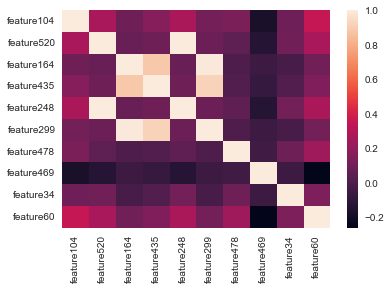

In [ ]:
X_trainshap.corr()
sns.heatmap(X_trainshap.corr())

In [ ]:
#Boruta Shap function with SVC
#scaled data is used

def BorutaSVCFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelsvc = SVC(probability=True)
    modelsvc.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelsvc,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

In [ ]:
X_trainsvc= BorutaSVCFeatureSelection(imputed_train,y_train)

  0%|          | 0/100 [00:00<?, ?it/s]


Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Boruta Shap function with KNN
#KNN is distance base algroritm. Scaled data is used

def BorutaknnFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelknn = KNeighborsClassifier()
    modelknn.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelknn,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


10 attributes confirmed important: ['feature248', 'feature164', 'feature34', 'feature478', 'feature435', 'feature104', 'feature469', 'feature60', 'feature299', 'feature520']
456 attributes confirmed unimportant: ['feature122', 'feature468', 'feature183', 'feature556', 'feature130', 'feature129', 'feature273', 'feature564', 'feature571', 'feature488', 'feature117', 'feature197', 'feature584', 'feature471', 'feature124', 'feature511', 'feature171', 'feature544', 'feature115', 'feature89', 'feature214', 'feature134', 'feature245', 'feature309', 'feature586', 'feature475', 'feature201', 'feature473', 'feature116', 'feature85', 'feature133', 'feature367', 'feature33', 'feature10', 'feature46', 'feature149', 'feature96', 'feature363', 'feature54', 'feature196', 'feature449', 'feature101', 'feature500', 'feature207', 'feature494', 'feature281', 'feature141', 'feature44', 'feature74', 'feature341', 'feature9', 'feature470', 'feature283', 'feature453', 'feature11', 'feature21', 'feature446', 'f

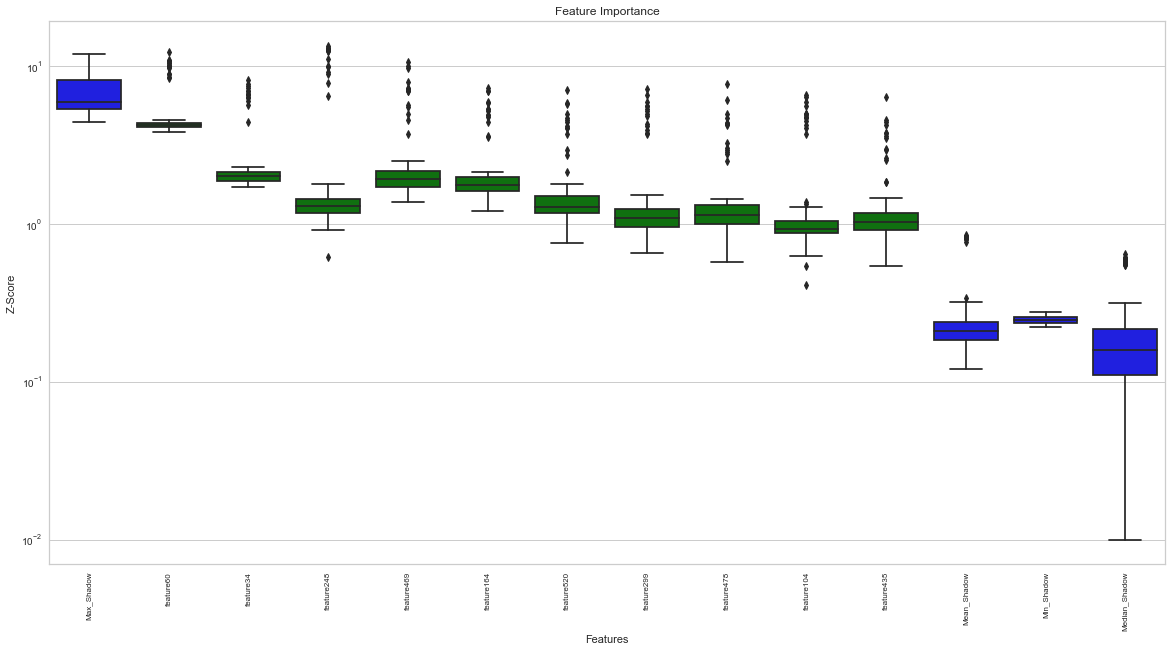

In [ ]:
X_trainknnscaled= BorutaknnFeatureSelection(imputed_train,y_train)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Boruta Shap function with XGBOOST

def BorutaxgbFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define XGBClassifier
    modelxgb = XGBClassifier()
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelxgb,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False)
    feature_selector.plot(which_features='accepted', figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

  0%|          | 0/100 [00:00<?, ?it/s]

[10:07:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  1%|          | 1/100 [00:01<01:52,  1.13s/it]

[10:07:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  2%|▏         | 2/100 [00:02<01:50,  1.12s/it]

[10:07:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  3%|▎         | 3/100 [00:03<01:50,  1.14s/it]

[10:07:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  4%|▍         | 4/100 [00:04<01:49,  1.14s/it]

[10:07:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  5%|▌         | 5/100 [00:05<01:52,  1.19s/it]

[10:07:37] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  6%|▌         | 6/100 [00:07<01:52,  1.20s/it]

[10:07:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  7%|▋         | 7/100 [00:08<01:50,  1.19s/it]

[10:07:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  8%|▊         | 8/100 [00:09<01:49,  1.19s/it]

[10:07:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  9%|▉         | 9/100 [00:10<01:52,  1.24s/it]

[10:07:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 10%|█         | 10/100 [00:12<01:54,  1.27s/it]

[10:07:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 11%|█         | 11/100 [00:13<01:52,  1.26s/it]

[10:07:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 12%|█▏        | 12/100 [00:14<01:51,  1.27s/it]

[10:07:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 13%|█▎        | 13/100 [00:15<01:52,  1.30s/it]

[10:07:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 14%|█▍        | 14/100 [00:17<01:59,  1.39s/it]

[10:07:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 15%|█▌        | 15/100 [00:18<01:38,  1.16s/it]

[10:07:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 16%|█▌        | 16/100 [00:18<01:16,  1.10it/s]

[10:07:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 17%|█▋        | 17/100 [00:18<01:00,  1.38it/s]

[10:07:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 18%|█▊        | 18/100 [00:19<00:48,  1.70it/s]

[10:07:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 19%|█▉        | 19/100 [00:19<00:40,  1.98it/s]

[10:07:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 20/100 [00:19<00:35,  2.25it/s]

[10:07:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 21%|██        | 21/100 [00:20<00:31,  2.53it/s]

[10:07:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 22%|██▏       | 22/100 [00:20<00:28,  2.78it/s]

[10:07:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 23%|██▎       | 23/100 [00:20<00:25,  3.00it/s]

[10:07:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 24%|██▍       | 24/100 [00:20<00:23,  3.19it/s]

[10:07:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 25%|██▌       | 25/100 [00:21<00:22,  3.34it/s]

[10:07:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 26%|██▌       | 26/100 [00:21<00:22,  3.24it/s]

[10:07:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 27%|██▋       | 27/100 [00:21<00:23,  3.08it/s]

[10:07:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 28%|██▊       | 28/100 [00:22<00:22,  3.15it/s]

[10:07:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▉       | 29/100 [00:22<00:22,  3.18it/s]

[10:07:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 30%|███       | 30/100 [00:22<00:22,  3.11it/s]

[10:07:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 31%|███       | 31/100 [00:23<00:22,  3.09it/s]

[10:07:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 32%|███▏      | 32/100 [00:23<00:21,  3.09it/s]

[10:07:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 33/100 [00:23<00:21,  3.10it/s]

[10:07:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 34%|███▍      | 34/100 [00:24<00:21,  3.08it/s]

[10:07:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 35%|███▌      | 35/100 [00:24<00:20,  3.13it/s]

[10:07:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 36%|███▌      | 36/100 [00:24<00:20,  3.18it/s]

[10:07:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 37%|███▋      | 37/100 [00:24<00:20,  3.14it/s]

[10:07:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 38%|███▊      | 38/100 [00:25<00:19,  3.12it/s]

[10:07:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 39%|███▉      | 39/100 [00:25<00:19,  3.19it/s]

[10:07:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 40/100 [00:25<00:18,  3.22it/s]

[10:07:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████      | 41/100 [00:26<00:18,  3.11it/s]

[10:07:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 42%|████▏     | 42/100 [00:26<00:18,  3.11it/s]

[10:07:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 43%|████▎     | 43/100 [00:26<00:18,  3.16it/s]

[10:07:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 44%|████▍     | 44/100 [00:27<00:18,  3.06it/s]

[10:07:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 45%|████▌     | 45/100 [00:27<00:17,  3.13it/s]

[10:07:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 46%|████▌     | 46/100 [00:27<00:16,  3.22it/s]

[10:07:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 47%|████▋     | 47/100 [00:28<00:16,  3.28it/s]

[10:07:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 48%|████▊     | 48/100 [00:28<00:15,  3.28it/s]

[10:08:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 49%|████▉     | 49/100 [00:28<00:15,  3.25it/s]

[10:08:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 50/100 [00:29<00:15,  3.21it/s]

[10:08:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 51%|█████     | 51/100 [00:29<00:15,  3.24it/s]

[10:08:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 52%|█████▏    | 52/100 [00:29<00:15,  3.20it/s]

[10:08:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 53%|█████▎    | 53/100 [00:30<00:15,  3.09it/s]

[10:08:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 54%|█████▍    | 54/100 [00:30<00:14,  3.19it/s]

[10:08:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 56%|█████▌    | 56/100 [00:30<00:12,  3.39it/s]

[10:08:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:08:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 57%|█████▋    | 57/100 [00:31<00:12,  3.49it/s]

[10:08:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 58%|█████▊    | 58/100 [00:31<00:11,  3.53it/s]

[10:08:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▉    | 59/100 [00:31<00:11,  3.57it/s]

[10:08:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 60/100 [00:32<00:11,  3.37it/s]

[10:08:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 61%|██████    | 61/100 [00:32<00:12,  3.02it/s]

[10:08:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 62%|██████▏   | 62/100 [00:32<00:12,  3.03it/s]

[10:08:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 63%|██████▎   | 63/100 [00:33<00:12,  3.08it/s]

[10:08:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 64%|██████▍   | 64/100 [00:33<00:11,  3.23it/s]

[10:08:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 65%|██████▌   | 65/100 [00:33<00:11,  3.18it/s]

[10:08:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 66%|██████▌   | 66/100 [00:33<00:10,  3.27it/s]

[10:08:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 67/100 [00:34<00:09,  3.33it/s]

[10:08:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 68%|██████▊   | 68/100 [00:34<00:09,  3.25it/s]

[10:08:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 69%|██████▉   | 69/100 [00:34<00:09,  3.21it/s]

[10:08:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 70%|███████   | 70/100 [00:35<00:09,  3.31it/s]

[10:08:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████   | 71/100 [00:35<00:08,  3.44it/s]

[10:08:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 72/100 [00:35<00:08,  3.42it/s]

[10:08:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 73%|███████▎  | 73/100 [00:36<00:07,  3.45it/s]

[10:08:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 74%|███████▍  | 74/100 [00:36<00:07,  3.43it/s]

[10:08:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 75%|███████▌  | 75/100 [00:36<00:07,  3.32it/s]

[10:08:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 76/100 [00:36<00:07,  3.39it/s]

[10:08:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 78%|███████▊  | 78/100 [00:37<00:06,  3.49it/s]

[10:08:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:08:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|███████▉  | 79/100 [00:37<00:05,  3.55it/s]

[10:08:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 80/100 [00:38<00:05,  3.57it/s]

[10:08:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 81%|████████  | 81/100 [00:38<00:05,  3.41it/s]

[10:08:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 82%|████████▏ | 82/100 [00:38<00:05,  3.28it/s]

[10:08:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 83/100 [00:38<00:05,  3.34it/s]

[10:08:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 84%|████████▍ | 84/100 [00:39<00:05,  3.19it/s]

[10:08:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 85%|████████▌ | 85/100 [00:39<00:04,  3.23it/s]

[10:08:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 86%|████████▌ | 86/100 [00:39<00:04,  3.22it/s]

[10:08:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 87%|████████▋ | 87/100 [00:40<00:03,  3.32it/s]

[10:08:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 88%|████████▊ | 88/100 [00:40<00:03,  3.39it/s]

[10:08:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 89%|████████▉ | 89/100 [00:40<00:03,  3.36it/s]

[10:08:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|█████████ | 90/100 [00:41<00:02,  3.34it/s]

[10:08:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 91%|█████████ | 91/100 [00:41<00:02,  3.29it/s]

[10:08:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 92%|█████████▏| 92/100 [00:41<00:02,  3.21it/s]

[10:08:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 93/100 [00:42<00:02,  3.26it/s]

[10:08:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|█████████▍| 94/100 [00:42<00:01,  3.30it/s]

[10:08:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|█████████▌| 95/100 [00:42<00:01,  3.24it/s]

[10:08:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 96%|█████████▌| 96/100 [00:42<00:01,  3.14it/s]

[10:08:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 97/100 [00:43<00:00,  3.18it/s]

[10:08:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|█████████▊| 98/100 [00:43<00:00,  3.11it/s]

[10:08:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 99%|█████████▉| 99/100 [00:43<00:00,  3.22it/s]

[10:08:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


3 attributes confirmed important: ['feature1', 'feature118', 'feature60']
463 attributes confirmed unimportant: ['feature122', 'feature468', 'feature183', 'feature556', 'feature130', 'feature129', 'feature273', 'feature564', 'feature571', 'feature488', 'feature117', 'feature197', 'feature584', 'feature471', 'feature124', 'feature511', 'feature171', 'feature544', 'feature115', 'feature89', 'feature214', 'feature134', 'feature245', 'feature309', 'feature586', 'feature435', 'feature475', 'feature201', 'feature473', 'feature116', 'feature85', 'feature133', 'feature367', 'feature33', 'feature10', 'feature46', 'feature149', 'feature96', 'feature363', 'feature54', 'feature196', 'feature449', 'feature101', 'feature500', 'feature207', 'feature494', 'feature281', 'feature141', 'feature44', 'feature74', 'feature341', 'feature9', 'feature470', 'feature283', 'feature453', 'feature11', 'feature21', 'feature446', 'feature216', 'feature61', 'feature209', 'feature72', 'feature97', 'feature162', 'featur

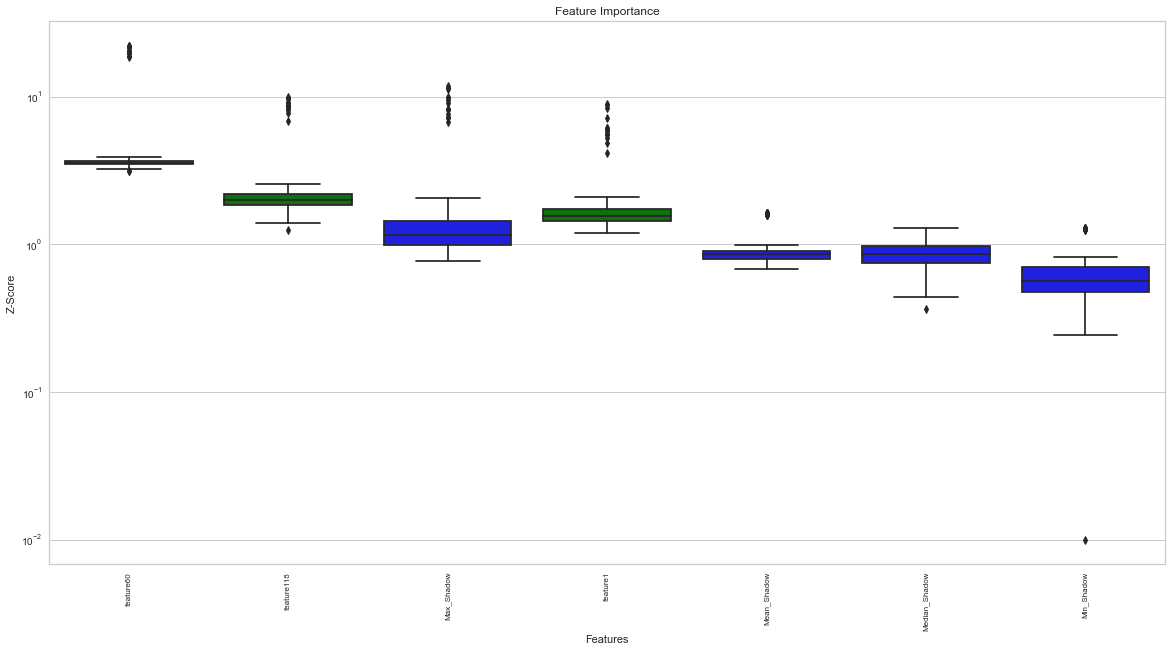

<AxesSubplot:>

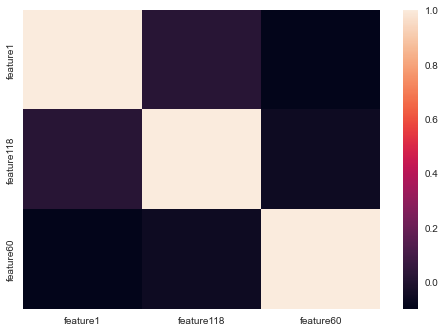

In [ ]:
X_trainxgb= BorutaxgbFeatureSelection(retransformed_train,y_train)
X_trainxgb.corr()
sns.heatmap(X_trainxgb.corr())

# Checking

In [ ]:
'feature_ranking

SyntaxError: EOL while scanning string literal (Temp/ipykernel_10320/4140504645.py, line 1)

In [ ]:
from sklearn.inspection import permutation_importance

### Visualisation feature ranking

In [ ]:
# array to dataframe 
'boruta_ranking = pd.DataFrame(data=feature_ranking, index=retransformed_train.columns.values, columns=['values'])

SyntaxError: invalid syntax (Temp/ipykernel_23612/1230069460.py, line 2)

In [ ]:
#boruta_ranking
boruta_ranking

,values
feature1,3
feature2,358
feature3,260
feature4,132
feature5,436
...,...
feature586,203
feature587,191
feature588,39
feature589,178


In [ ]:
boruta_ranking['Variable'] = boruta_ranking.index
boruta_ranking.sort_values(['values'], ascending=True, inplace=True)

In [ ]:
boruta_ranking_30=boruta_ranking.loc[boruta_ranking['values']<=30]

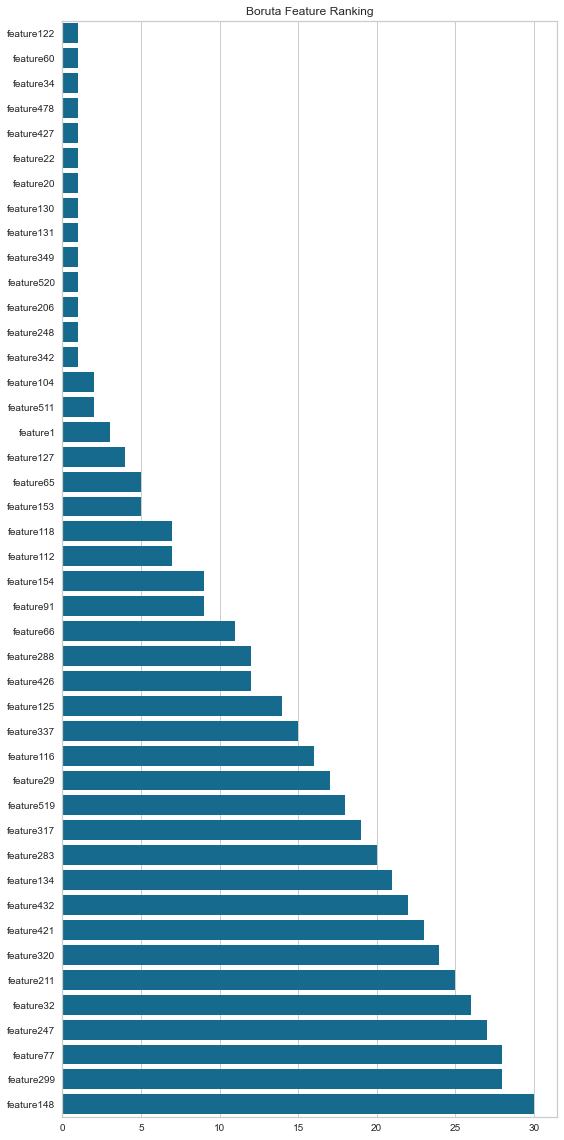

In [ ]:
fig,ax = plt.subplots(figsize=(8,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking_30, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

Text(0, 0.5, '')

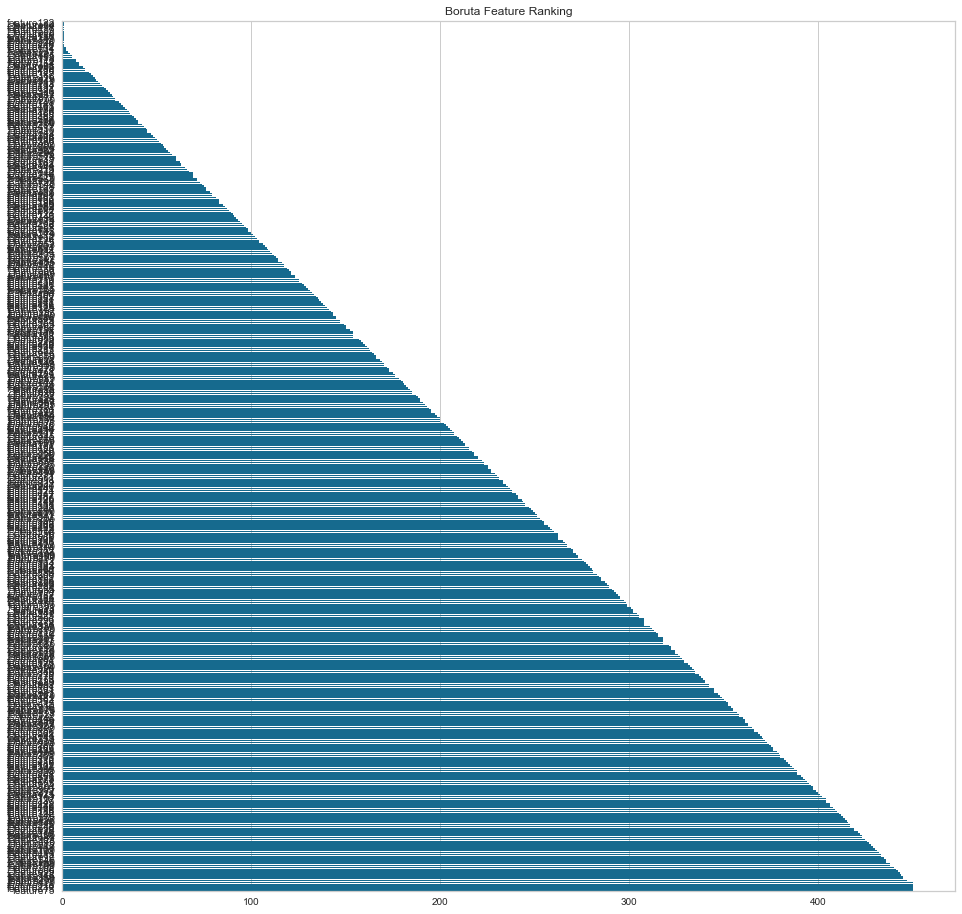

In [ ]:
fig,ax = plt.subplots(figsize=(16,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
#plt.tight_layout()

# Checking - manual Boruta without the function

In [ ]:
# 
# # prepare the data for boruta by fitting it to random forest Classifier 
#from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(imputed_train, y_train)
#iteration=200
# define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1,max_iter=iteration)

# find all relevant features
#feat_selector.fit(np.array(imputed_train),np.array(y_train))
#print("Ranking: ",feat_selector.ranking_)          
#print("No. of significant features: ", feat_selector.n_features_) 
#feat_selector.support_
#green_area = imputed_train.columns[feat_selector.support_].to_list()
#blue_area = imputed_train.columns[feat_selector.ranking_].to_list()
#X_best_features= feat_selector.transform(imputed_train.to_numpy())

# Preparation of test data

## reducing dimensionality

### missing values 

In [ ]:
x_test

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,100.0,105.1278,0.1190,1.4615,-0.0109,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,100.0,102.4522,0.1227,1.4444,-0.0014,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,100.0,112.5811,0.1229,1.3838,-0.0125,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,100.0,90.3111,0.1219,1.4844,-0.0288,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,100.0,99.5133,0.1249,1.3331,-0.0126,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,100.0,102.3622,0.1208,1.3952,-0.0198,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,-0.0014,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,100.0,103.3778,0.1205,1.6486,-0.0239,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,100.0,95.2056,0.1249,1.4939,0.0096,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [ ]:
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [ ]:
x_test_na=x_test.drop(axis=1, columns=x_train_na.index)

In [ ]:
x_test_na

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,100.0,105.1278,0.1190,1.4615,-0.0109,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,100.0,102.4522,0.1227,1.4444,-0.0014,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,100.0,112.5811,0.1229,1.3838,-0.0125,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,100.0,90.3111,0.1219,1.4844,-0.0288,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,100.0,99.5133,0.1249,1.3331,-0.0126,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,100.0,102.3622,0.1208,1.3952,-0.0198,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,-0.0014,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,100.0,103.3778,0.1205,1.6486,-0.0239,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,100.0,95.2056,0.1249,1.4939,0.0096,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


#### filter features of x_train_new only rather than choosing threshold

In [ ]:
x_train_new
#x_test_new= x_test[]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
443,3079.77,2354.51,2207.0444,1269.6078,1.7571,100.0,97.0189,0.1221,1.4607,0.0155,...,0.0059,68.7444,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
760,3001.36,2491.23,2155.3111,918.2161,1.2753,100.0,105.0478,0.1227,1.4206,-0.0052,...,NaN,NaN,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
479,3042.78,2377.89,2173.4556,1433.6732,1.0304,100.0,110.5422,0.1245,1.4964,0.0204,...,NaN,NaN,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
362,3018.64,2401.80,2224.0000,1510.0797,1.5611,100.0,99.8300,0.1199,1.4428,-0.0110,...,0.0038,49.7490,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
662,3020.29,2433.99,2217.8111,1744.7771,0.9618,100.0,100.1789,0.1218,1.4950,-0.0097,...,NaN,NaN,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3057.31,2481.53,2214.9333,1663.7024,1.0203,100.0,100.4456,0.1247,1.4830,-0.0328,...,NaN,NaN,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
821,3009.71,2565.53,2224.6778,1308.6479,1.3907,100.0,101.1333,0.1208,1.4440,-0.0079,...,NaN,NaN,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
213,3034.34,2631.47,2179.0445,2028.2208,1.5552,100.0,95.4256,0.1234,1.4281,0.0049,...,NaN,NaN,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1556,3025.21,2503.30,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3687,-0.0070,...,0.0016,46.1076,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


### constant volatility 

In [ ]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_test_std=x_test_na.drop(axis=1, columns=x_train_new_std.index)

In [ ]:
x_test_std

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


### Outlier treatment of test data

In [ ]:
x_test_3s=x_test_std.copy()
zscore(x_test_3s,x_test_3s.columns,3)

In [ ]:
x_test_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


## imputation

### KNN Imputation

In [ ]:
#no need to scale for test data
#x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test_3s), columns=x_test_3s.columns)
#x_test_scaled

In [ ]:
x_test_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [ ]:
imputed_test = pd.DataFrame(knn.transform(x_test_3s), columns = x_test_3s.columns)

In [ ]:
imputed_test.isna().any().any()

False

In [ ]:
imputed_test

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.006000,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
1,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,0.386595,0.392809,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
2,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,0.292519,0.327173,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
3,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.003200,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
4,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,0.242541,0.225742,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,0.352786,0.500538,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
310,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.007000,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
311,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.001900,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
312,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,0.457152,0.523901,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


## Unscaling of imputed test and filtering the features of test dataset

In [ ]:
X_test = imputed_test.filter(final_features)

In [ ]:
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)

In [ ]:
X_test

,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature520
0,12.5412,-5287.50,9.4336,-1.2400,15.60,-2.3640,0.7865,9.94,0.018600,3.4391,0.018700,1.4793,6.5927,4.018800
1,12.4922,-5613.50,8.7219,-4.1518,15.92,-0.1419,0.8080,17.13,0.126910,4.7775,0.026900,0.7327,11.9817,0.115731
2,12.5204,-5489.75,9.1637,-5.1491,15.87,-1.2770,0.7223,9.20,0.000000,2.7074,0.020800,0.9544,6.2464,0.000000
3,12.6082,-5100.00,8.8097,-5.6500,15.99,0.0000,0.7672,5.49,0.020200,1.7046,0.028300,0.5319,3.7154,4.331300
4,12.3996,-5416.50,8.2720,5.3973,15.73,-0.5677,0.5325,6.95,0.128980,2.4584,0.028800,0.9850,4.6771,0.117461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,12.5510,-5012.75,8.7635,-1.4027,15.80,-1.7970,0.5662,5.51,0.128980,1.7381,0.018400,1.4588,3.6998,0.117461
310,12.4192,-5338.75,8.1728,4.6964,15.69,0.0000,0.5768,6.25,0.094703,2.0250,0.249953,0.8921,4.1743,0.087116
311,12.4871,-4520.75,9.1784,20.0455,15.87,0.0946,0.7484,9.60,0.195900,2.5763,0.021100,1.2708,6.4725,42.711700
312,12.5661,-5336.75,8.7402,-2.1409,15.78,-3.7790,0.7948,6.62,0.094780,2.0725,0.022900,0.4862,4.4298,0.087291


In [ ]:
X_test5 

,feature476,feature421,feature427,feature283,feature148,feature118,feature342,feature22,feature60,feature478
0,3.9269,2.0977,1.4793,0.0068,0.0202,59.762100,3.4391,-5287.50,-1.2400,6.5927
1,4.6798,0.5965,0.7327,0.0019,0.0058,58.960300,4.7775,-5613.50,-4.1518,11.9817
2,3.0835,1.1830,0.9544,0.0040,0.0115,58.718800,2.7074,-5489.75,-5.1491,6.2464
3,3.3519,0.8983,0.5319,0.0028,0.0088,55.905200,1.7046,-5100.00,-5.6500,3.7154
4,5.1716,1.9874,0.9850,0.0063,0.0190,59.412600,2.4584,-5416.50,5.3973,4.6771
...,...,...,...,...,...,...,...,...,...,...
309,4.5614,1.7080,1.4588,0.0055,0.0165,55.407117,1.7381,-5012.75,-1.4027,3.6998
310,3.7902,1.1587,0.8921,0.0039,0.0113,58.011900,2.0250,-5338.75,4.6964,4.1743
311,4.3776,3.3921,1.2708,0.0104,0.0321,59.210900,2.5763,-4520.75,20.0455,6.4725
312,4.3990,0.5672,0.4862,0.0018,0.0056,59.057500,2.0725,-5336.75,-2.1409,4.4298


# Balancing 

In [ ]:
def Sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [ ]:
X_resampled, y_resampled = Sampling(X_train, y_train,'SMOTE')

Counter({-1: 1170, 1: 1170})


In [ ]:
X_resampled

,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature520
0,12.368600,-4750.750000,8.691500,0.699100,15.760000,0.000000,0.820300,9.220000,0.015200,2.654700,0.023700,1.315500,6.026600,3.292400
1,12.495900,-5410.750000,8.300600,-1.417300,15.760000,0.283800,0.829100,7.310000,0.031060,2.098900,0.027200,0.659300,4.821800,6.713220
2,12.555300,-6456.750000,8.741800,10.235500,15.650000,-0.283800,0.543800,8.800000,0.034500,2.501200,0.016300,1.540300,6.158900,7.439200
3,12.446900,-5775.000000,8.682900,9.851800,15.730000,0.047300,0.804800,7.770000,0.260816,2.432900,0.030000,1.642200,5.061200,61.263283
4,12.461800,-6900.500000,8.589100,1.033600,15.900000,0.425800,0.761100,11.060000,0.017220,3.265300,0.024300,0.800600,7.482800,3.731840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,12.489219,-6415.923312,11.734260,25.670624,15.886523,-0.359906,0.681574,31.624356,0.034554,9.953835,0.024291,1.044275,26.303801,7.395971
2336,12.524649,-5398.137511,8.883645,-1.395501,15.825622,0.907880,0.804828,5.958196,0.043435,1.641890,0.021106,0.770926,4.133259,9.185865
2337,12.493209,-5274.250000,9.094346,-3.399411,15.814912,-0.491810,0.714429,13.452644,0.038135,3.782218,0.024138,0.918683,9.476738,8.158229
2338,12.594568,-5162.360438,8.712101,10.389921,15.801816,0.596983,0.821190,12.833825,0.086584,3.948903,0.038554,1.850067,8.710258,18.158136


In [ ]:
# Create the random grid
rf_params = {'n_estimators': [25, 50],
               'criterion' : ['entropy', 'gini'],
               'max_features': ['sqrt', 'auto'],
               'max_depth': [3, 10],
               'min_samples_split': [75,100],
               'min_samples_leaf': [1, 10],
               'max_samples' : [110, 200]
              }

In [ ]:
# Create a base model to tune
rf = RandomForestClassifier(random_state=100)

# Grid Search
rf_random = GridSearchCV(estimator = rf, param_grid = rf_params, scoring='roc_auc', cv = 5, verbose=1)

# Fit the random search model
rf_random.fit(X_resampled, y_resampled)
feature_selector7 = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=100)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
# Printing the best Parameters and best estimator

#Printing the best estimator

print('\n Best estimator:')
print(rf_random.best_estimator_)

print('\n Best hyperparameters:')
print(rf_random.best_params_)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       max_samples=200, min_samples_split=75, n_estimators=50,
                       random_state=100)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 200, 'min_samples_leaf': 1, 'min_samples_split': 75, 'n_estimators': 50}


In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(rf_random.best_estimator_, X_resampled, y_resampled, cv=cv, scoring = 'roc_auc')
print(scores.mean())
# fit
rf_random.best_estimator_.fit(X_resampled, y_resampled)    
# predict
y_pred_test = rf_random.best_estimator_.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

0.8801592519541238
Test Accuracy :  0.8089171974522293


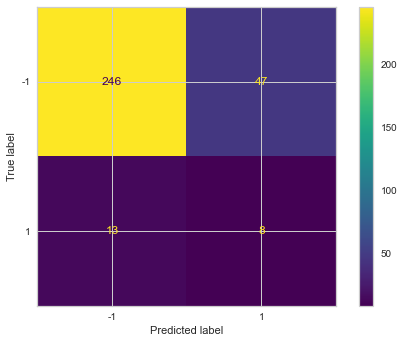

              precision    recall  f1-score   support

          -1       0.95      0.84      0.89       293
           1       0.15      0.38      0.21        21

    accuracy                           0.81       314
   macro avg       0.55      0.61      0.55       314
weighted avg       0.90      0.81      0.85       314



In [ ]:
# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=rf_random.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_random.best_estimator_.classes_)
disp.plot()
plt.show()
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test)) 

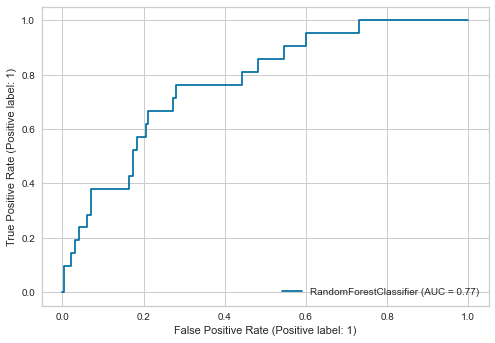

In [ ]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(rf_random.best_estimator_, X_test, y_test)
plt.show()

# Build Model

## Random forest

### function for running model and printing accuracy score 

In [ ]:
def run_model(X, y,X_test,y_test):
    # building model before balancing data
    clf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
    clf.fit(X,y)
    y_predicted_test= clf.predict(X_test)
    score1= accuracy_score(y_test, y_predicted_test)
    return score1

In [ ]:
#### run model on training data before sampling 
#run_model(imputed_train,y_train,imputed_test,y_test)
# train the model on feature selected X_train and y_train (without sampling ) and test it on prepared test data 
run_model(X_train,y_train,X_test,y_test)

0.9331210191082803

In [ ]:
#### run model on training data after sampling 
run_model(X_resampled,y_resampled,X_test,y_test)

0.8407643312101911

In [ ]:
run_model(X_resampled5, y_resampled5,X_test5,y_test)

0.7898089171974523